<a href="https://colab.research.google.com/github/Pansyhb/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_Good_04_13ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.4 MB/s eta 0:00:00


In [2]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 259 (delta 16), reused 1 (delta 1), pack-reused 225
Receiving objects: 100% (259/259), 8.22 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (122/122), done.


## 2.2 Setup of Data Collection Functions

In [3]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [4]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [5]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1432 non-null   datetime64[ns]
 1   open       1432 non-null   float64       
 2   high       1432 non-null   float64       
 3   low        1432 non-null   float64       
 4   close      1432 non-null   float64       
 5   adj_close  1432 non-null   float64       
 6   volume     1432 non-null   int64         
 7   ticker     1432 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.6+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [6]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [7]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-7-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-7-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-7-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

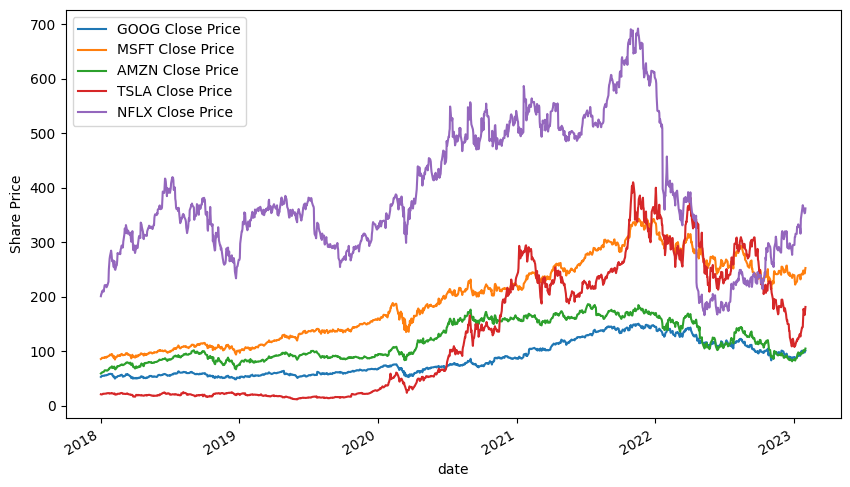

KeyError: ignored

In [11]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [12]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [13]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 52s]
val_loss: 0.0034681507386267185

Best val_loss So Far: 0.0010364147601649165
Total elapsed time: 00h 35m 58s
36/36 [==============================] - 1s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
[0.00145565380807966, 0.00145565380807966]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'relu', 'dropout1': 0.7, 'neurons_hidden1': 20, 'dropout2': 0.4, 'neurons_hidden2': 30, 'dropout3': 0.1, 'neurons_hidden3': 30}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [14]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


4/4 [==============================] - 0s 5ms/step


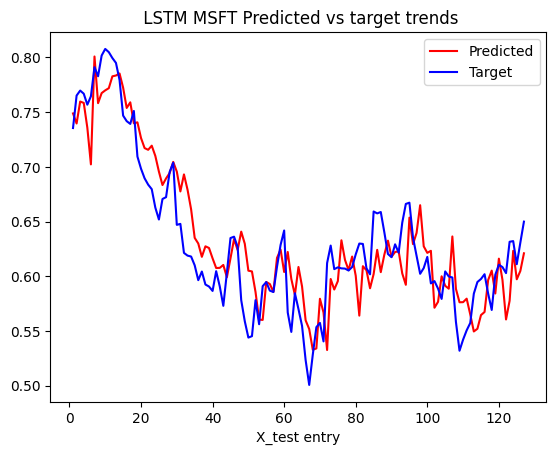

In [15]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape

import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [16]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [17]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 1s 7ms/step


(1270, 1)

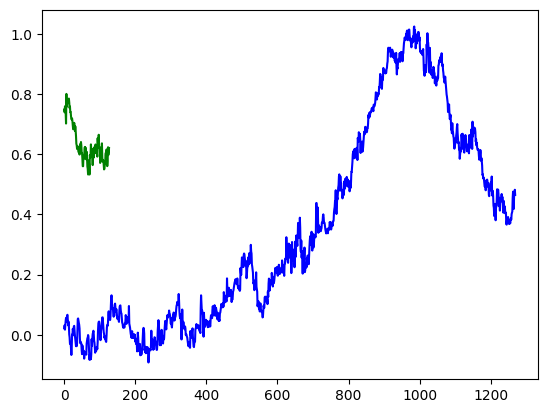

In [18]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()




##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [19]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [20]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [22]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/f0qw0nif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/_tc6yruh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88014', 'data', 'file=/tmp/tmpdz0a4lo5/f0qw0nif.json', 'init=/tmp/tmpdz0a4lo5/_tc6yruh.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model5rjksf9y/prophet_model-20230413181929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/95vapzkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/0pd417rb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2700', 'data', 'file=/tmp/tmpdz0a4lo5/95vapzkk.json', 'init=/tmp/tmpdz0a4lo5/0pd417rb.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modeli3brsokq/prophet_model-20230413181931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/z_d7ri65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/8nzs2gqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


18:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/u8zavh40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/6o4oiinz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51854', 'data', 'file=/tmp/tmpdz0a4lo5/u8zavh40.json', 'init=/tmp/tmpdz0a4lo5/6o4oiinz.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelr_3idh8h/prophet_model-20230413182055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/lpkogn91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/4u0dsoql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/quazhp0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64238', 'data', 'file=/tmp/tmpdz0a4lo5/f3tjf2cz.json', 'init=/tmp/tmpdz0a4lo5/quazhp0h.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model8d016gv1/prophet_model-20230413182150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/1l5xbwkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/efywzd_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83404', 'data', 'file=/tmp/tmpdz0a4lo5/1l5xbwkz.json', 'init=/tmp/tmpdz0a4lo5/efywzd_9.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelo1kz0kr4/prophet_model-20230413182152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/c0q4rhjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/b8ojr9i8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/sspr8u05.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8310', 'data', 'file=/tmp/tmpdz0a4lo5/65x4mull.json', 'init=/tmp/tmpdz0a4lo5/sspr8u05.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model2jwpaqki/prophet_model-20230413182245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/st3shbnl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/y93h1aek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96516', 'data', 'file=/tmp/tmpdz0a4lo5/st3shbnl.json', 'init=/tmp/tmpdz0a4lo5/y93h1aek.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelpd5w2kh7/prophet_model-20230413182246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/uwy71cht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/92jeogn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/y01vmrsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68178', 'data', 'file=/tmp/tmpdz0a4lo5/u5uvzj4x.json', 'init=/tmp/tmpdz0a4lo5/y01vmrsp.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model8pz012mb/prophet_model-20230413182346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/h0y6diuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/6elhxlif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86967', 'data', 'file=/tmp/tmpdz0a4lo5/h0y6diuw.json', 'init=/tmp/tmpdz0a4lo5/6elhxlif.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelf1rxt011/prophet_model-20230413182348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/y0zl_8ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/gtays8f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62824', 'data', 'file=/tmp/tmpdz0a4lo5/qz082dh0.json', 'init=/tmp/tmpdz0a4lo5/rkg4ouh1.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelt0rr4fhq/prophet_model-20230413182447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/jvz0vhqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/24avrhye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48630', 'data', 'file=/tmp/tmpdz0a4lo5/jvz0vhqz.json', 'init=/tmp/tmpdz0a4lo5/24avrhye.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model69n6ph2p/prophet_model-20230413182449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/mm78i1xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/k20amp3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


18:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/d3q25fes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ml9qrubu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72914', 'data', 'file=/tmp/tmpdz0a4lo5/d3q25fes.json', 'init=/tmp/tmpdz0a4lo5/ml9qrubu.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelsq1gnn1_/prophet_model-20230413182615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/dbqpih8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/l2wwdfmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


18:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/4f48iw28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/1pf3udzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44200', 'data', 'file=/tmp/tmpdz0a4lo5/4f48iw28.json', 'init=/tmp/tmpdz0a4lo5/1pf3udzm.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modeljq3w1g4v/prophet_model-20230413182813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/2bp2re_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/z5fa7wcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


18:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/2qfinbfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/83hh6pyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24788', 'data', 'file=/tmp/tmpdz0a4lo5/2qfinbfw.json', 'init=/tmp/tmpdz0a4lo5/83hh6pyi.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelukf1zkpi/prophet_model-20230413183016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/73n541q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/pv0k8apz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


18:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/w08h25jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/fa4vx6p_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16257', 'data', 'file=/tmp/tmpdz0a4lo5/w08h25jz.json', 'init=/tmp/tmpdz0a4lo5/fa4vx6p_.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelk9d1b_qv/prophet_model-20230413183217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/5k0qwa9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/r4itqmo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


18:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/m9dunoki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/kukrqi4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4727', 'data', 'file=/tmp/tmpdz0a4lo5/m9dunoki.json', 'init=/tmp/tmpdz0a4lo5/kukrqi4v.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modeluix41d0c/prophet_model-20230413183423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/0tqlrg2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/e6pp4i1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


18:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/hgpkhfdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/fvwy3en9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8294', 'data', 'file=/tmp/tmpdz0a4lo5/hgpkhfdq.json', 'init=/tmp/tmpdz0a4lo5/fvwy3en9.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model3216f_q0/prophet_model-20230413183638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/cakg71rs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/h7we0f1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


18:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/uoxeg3ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/utvw_fma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93713', 'data', 'file=/tmp/tmpdz0a4lo5/uoxeg3ro.json', 'init=/tmp/tmpdz0a4lo5/utvw_fma.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modeljddyjh2a/prophet_model-20230413184014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/tgvcqg7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/1uv_16wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


18:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ftgckmjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/wot22zyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65314', 'data', 'file=/tmp/tmpdz0a4lo5/ftgckmjp.json', 'init=/tmp/tmpdz0a4lo5/wot22zyg.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelnk_1xuy8/prophet_model-20230413184252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/yx24j7pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/4oj6f1bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


18:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/kno2qc3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/hc1x2wny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29503', 'data', 'file=/tmp/tmpdz0a4lo5/kno2qc3u.json', 'init=/tmp/tmpdz0a4lo5/hc1x2wny.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model3sdkda_t/prophet_model-20230413184526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/btltxkt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/2lo30g1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


18:48:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/wt34nh26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ts7iw3l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54146', 'data', 'file=/tmp/tmpdz0a4lo5/wt34nh26.json', 'init=/tmp/tmpdz0a4lo5/ts7iw3l6.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelq51qk56o/prophet_model-20230413184804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/04h_owkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/aq1euz2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


18:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/2gw42xzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ox0o5t7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96464', 'data', 'file=/tmp/tmpdz0a4lo5/2gw42xzc.json', 'init=/tmp/tmpdz0a4lo5/ox0o5t7i.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelvzy7yk0c/prophet_model-20230413185039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/qncmwdkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/i1j5x2ct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


18:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/sa5v97j9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/rqihnij_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3675', 'data', 'file=/tmp/tmpdz0a4lo5/sa5v97j9.json', 'init=/tmp/tmpdz0a4lo5/rqihnij_.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model5vkb_zzh/prophet_model-20230413185327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/fj8tnrcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/hau3g9sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Best parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Minimum cross-validation error: 185.1688513042688


### 4.3.1 Forecasting with Prophet

In [23]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [24]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ykkd3r_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ai6jxzqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76964', 'data', 'file=/tmp/tmpdz0a4lo5/ykkd3r_1.json', 'init=/tmp/tmpdz0a4lo5/ai6jxzqd.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelj6fhba1z/prophet_model-20230413185619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/4brf6u6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/ypqc0oom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40122', 'data', 'file=/tmp/tmpdz0a4lo5/4brf6u6i.json', 'init=/tmp/tmpdz0a4lo5/ypqc0oom.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modelnl6bl06h/prophet_model-20230413185621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/chxsuvkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/w99fyf9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [25]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/xy4vyunx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/f_6i30kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35121', 'data', 'file=/tmp/tmpdz0a4lo5/xy4vyunx.json', 'init=/tmp/tmpdz0a4lo5/f_6i30kh.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_model5fx1yzye/prophet_model-20230413190156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/3ymv8vmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/tmsxdnks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61541', 'data', 'file=/tmp/tmpdz0a4lo5/3ymv8vmp.json', 'init=/tmp/tmpdz0a4lo5/tmsxdnks.json', 'output', 'file=/tmp/tmpdz0a4lo5/prophet_modeluxrp4v5k/prophet_model-20230413190159.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/s0d5bcen.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0a4lo5/xkng8l8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [26]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [27]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [28]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'LSTM':LSTM_MSFT_yhat.flatten(), 'prophet':np.array(msft_train_data), }
msft_hybrid_df = pd.DataFrame(msft_hybrid)

#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()
msft_hybrid_df['prophet'] = scaler2.fit_transform(msft_hybrid_df[['prophet']])

#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))


36/36 [==============================] - 1s 8ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
y_hybrid (1143, 1)


In [29]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 11ms/step - loss: 0.1824 - mae: 0.3268
Epoch 2/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0515 - mae: 0.1818
Epoch 3/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0269 - mae: 0.1306
Epoch 4/300
48/48 [==============================] - 1s 12ms/step - loss: 0.0184 - mae: 0.1078
Epoch 5/300
48/48 [==============================] - 1s 10ms/step - loss: 0.0127 - mae: 0.0883
Epoch 6/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0094 - mae: 0.0762
Epoch 7/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0085 - mae: 0.0702
Epoch 8/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0083 - mae: 0.0699
Epoch 9/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0076 - mae: 0.0686
Epoch 10/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0083 - mae: 0.0704
Epoch 11/300
48/48 [==============================] - 1s 11ms

###4.4.2 LOSS and MAE

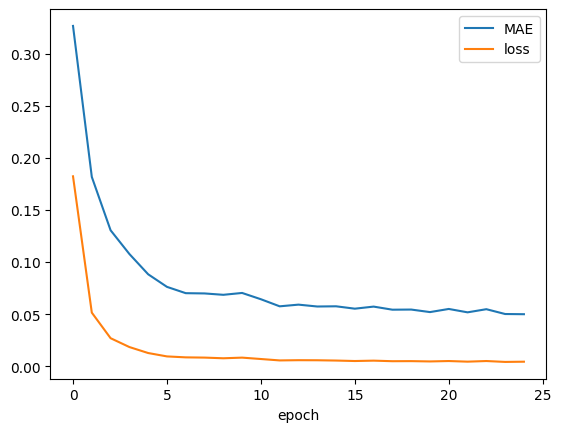

In [30]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [31]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [32]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 6ms/step


In [51]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 1s 7ms/step


In [56]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the mean square error of the predictions is {mse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return mse.result().numpy(), mae.result().numpy()

In [60]:
MSFT_x_test

array([[[0.74875677, 0.6553612 ],
        [0.73955536, 0.66882642],
        [0.75961328, 0.6667629 ],
        ...,
        [0.75812578, 0.70142667],
        [0.76731312, 0.8282618 ],
        [0.76981199, 0.835115  ]],

       [[0.73955536, 0.66882642],
        [0.75961328, 0.6667629 ],
        [0.75834572, 0.67396766],
        ...,
        [0.76731312, 0.8282618 ],
        [0.76981199, 0.835115  ],
        [0.77181065, 0.83932128]],

       [[0.75961328, 0.6667629 ],
        [0.75834572, 0.67396766],
        [0.7356962 , 0.67850899],
        ...,
        [0.76981199, 0.835115  ],
        [0.77181065, 0.83932128],
        [0.78264034, 0.85778715]],

       ...,

       [[0.56452668, 0.04653942],
        [0.56735849, 0.        ],
        [0.59651887, 0.00239654],
        ...,
        [0.56054485, 0.05658115],
        [0.57762992, 0.0558612 ],
        [0.62323117, 0.06269331]],

       [[0.56735849, 0.        ],
        [0.59651887, 0.00239654],
        [0.60515857, 0.05523186],
        .

In [64]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(msft_hybrid_df,y_hybrid)
linear_predictions_GOOG = linear_model.predict(GOOG_test_hybrid)
linear_predictions_MSFT = linear_model.predict(MSFT_test_hybrid)

###4.4.5 Predicted vs Actual Price

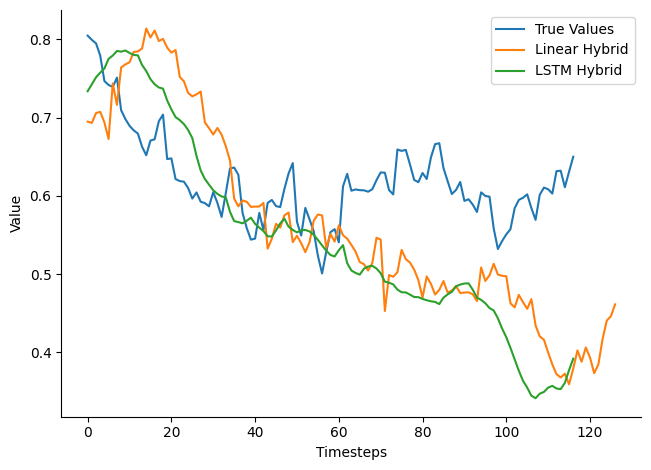

In [65]:
#plot MSFT predicition for Linear vs hybrid results
plt.plot(MSFT_y_test, label="True Values")
plt.plot(linear_predictions_MSFT, label="Linear Hybrid")
plt.plot(MSFT_predictions, label="LSTM Hybrid")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

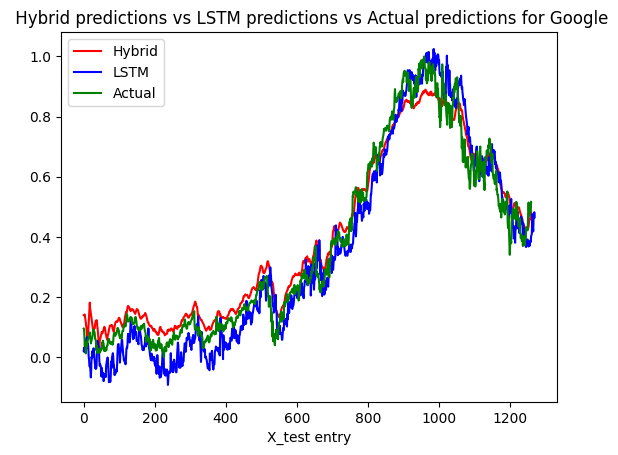

In [66]:
import matplotlib.pyplot as plt
x=np.arange(1,len(GOOG_y_test)+1, 1)
plt.plot(GOOG_predictions.flatten(), "r", label= "Hybrid")
plt.plot(LSTM_GOOG_yhat, "b", label= "LSTM")
plt.plot(GOOG_y_test, "g", label= "Actual")

plt.title(" Hybrid predictions vs LSTM predictions vs Actual predictions for Google")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [67]:
GOOG_scaler = []
MSFT_scaler = []

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [58]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


51/53 [===========================>..] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.0184

53/53 [==============================] - 4s 20ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 25ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 23ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 21ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 26ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 25ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 10/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 11/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 15/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 16/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 19/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 22/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 24/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 25/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 27/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 29/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 31/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 32/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 34/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 35/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 37/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 38/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 41/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 42/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 43/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 46/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 60/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 61/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 63/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 64/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 65/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 66/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 68/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 73/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 75/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 77/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 84/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 85/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 87/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 90/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 91/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 97/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 98/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 101/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 108/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 110/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 111/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 120/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 122/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 127/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 133/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 134/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 135/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 136/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 140/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 145/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 146/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 149/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 150/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 153/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

53/53 [==============================] - 1s 11ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 155/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

53/53 [==============================] - 1s 12ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 11ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 158/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 11ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 161/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 16ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 164/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 16ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 17ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 17ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 169/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 172/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 174/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 175/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 12ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 178/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 180/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 181/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 182/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 184/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 17ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 17ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 190/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 191/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 192/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 197/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 198/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.0202

53/53 [==============================] - 2s 12ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

53/53 [==============================] - 1s 11ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

53/53 [==============================] - 1s 12ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

53/53 [==============================] - 1s 12ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 11ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 6/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 11ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 7/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 12ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 8/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

53/53 [==============================] - 1s 11ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 9/200
52/53 [============================>.] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 10/200
53/53 [==============================] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 12ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 12ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 11ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 12ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 15/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 15ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 19/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 18ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 24/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 26/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 27/200
53/53 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 12ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 30/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 31/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 34/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 13ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 41/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 45/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 49/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 50/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 12ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 53/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 63/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 16ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 67/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 68/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 72/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 79/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 80/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 15ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 89/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 92/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 93/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 95/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 98/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 101/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 102/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 110/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 113/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 114/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 116/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 119/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 120/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 124/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 125/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 13ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 130/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 131/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 132/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 134/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 135/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 137/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 138/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 139/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 143/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 144/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 145/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 147/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 150/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 155/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 157/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 159/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 162/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 165/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 168/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 172/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 18ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 182/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 185/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 188/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 191/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 192/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 196/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.0168 - mean_squared_error: 0.0168

53/53 [==============================] - 3s 13ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 12ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 6/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 9/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 15/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 17/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 18/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 19/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 22/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 32/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 33/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 34/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 43/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 45/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 47/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 48/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 50/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 52/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 53/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 65/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 15ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 67/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 71/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 72/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 73/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 78/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 80/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 83/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 88/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 90/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 96/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 98/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 99/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 101/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 19ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 111/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 112/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 113/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 19ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 117/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 119/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 120/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 126/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 127/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 16ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 17ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 135/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 138/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118

53/53 [==============================] - 1s 14ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 142/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 144/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 145/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 146/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 147/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 148/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 150/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 152/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 153/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 155/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 157/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 164/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 12ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 168/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 171/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 172/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 174/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 182/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 185/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 187/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 190/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 192/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 193/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 195/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.0167

53/53 [==============================] - 3s 18ms/step - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 15ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 3/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 6/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 13/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 17/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 18/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 19ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 25/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 28/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 29/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 32/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 34/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 41/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 44/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 19ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 50/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 52/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 53/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 55/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 58/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 59/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 65/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 69/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 73/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 76/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 79/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 80/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 81/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 86/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 21ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 87/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 90/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 92/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 95/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 100/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 101/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 102/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 105/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 106/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 110/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 111/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 19ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 113/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 19ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 116/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 121/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 125/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 127/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 131/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 135/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 138/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 142/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 148/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 149/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 150/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 151/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 19ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 156/200
53/53 [==============================] - ETA: 0s - loss: 0.0321 - mean_squared_error: 0.0321

53/53 [==============================] - 1s 19ms/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.0176

53/53 [==============================] - 1s 17ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.0142

53/53 [==============================] - 1s 20ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 159/200
53/53 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.0152

53/53 [==============================] - 1s 19ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116

53/53 [==============================] - 1s 20ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115

53/53 [==============================] - 1s 15ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

53/53 [==============================] - 1s 14ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 163/200
52/53 [============================>.] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

53/53 [==============================] - 1s 14ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

53/53 [==============================] - 1s 13ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116

53/53 [==============================] - 1s 14ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119

53/53 [==============================] - 1s 13ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.0142

53/53 [==============================] - 1s 14ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 168/200
52/53 [============================>.] - ETA: 0s - loss: 0.0153 - mean_squared_error: 0.0153

53/53 [==============================] - 1s 13ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127

53/53 [==============================] - 1s 13ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 170/200
53/53 [==============================] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 171/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 1s 13ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

53/53 [==============================] - 1s 14ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 174/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

53/53 [==============================] - 1s 13ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 20ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 19ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 18ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 178/200
53/53 [==============================] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 20ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 17ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 20ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 19ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 187/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 15ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 190/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 192/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 195/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 196/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 197/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [62]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1, preds_df, targets

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets, preds_df, training_y =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_hybrid) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 1s 6ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


45/48 [===========================>..] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.0170

48/48 [==============================] - 2s 10ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 2/200
47/48 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

48/48 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/200
47/48 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

48/48 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

48/48 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/200
48/48 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 6/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 7/200
48/48 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

48/48 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 8/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/200
47/48 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 11/200
48/48 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

48/48 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 12/200
47/48 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 13/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 14/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 15/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 16/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 17/200
48/48 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 18/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 19/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 20/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 21/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 22/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 23/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 24/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 25/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 26/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 27/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 28/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 29/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 30/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 31/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 32/200
48/48 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 33/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 34/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 35/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 36/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 37/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 38/200
47/48 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 39/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 40/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 41/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

48/48 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 42/200
47/48 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 43/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 44/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 45/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 46/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/200
48/48 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 48/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 49/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 50/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 51/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 52/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 53/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 54/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 55/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 56/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 57/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 58/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 59/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 60/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 61/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 62/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 63/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 64/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 65/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 66/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 67/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 68/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 69/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 70/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 71/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 19ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 72/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 73/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 29ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 74/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 24ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 75/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 76/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 77/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 78/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 79/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 80/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 81/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 82/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 21ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 83/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 84/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 23ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 85/200
48/48 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 86/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 25ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 87/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 28ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 88/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 26ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 89/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 24ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 90/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 91/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 92/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 21ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 93/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 94/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 95/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 96/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 97/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 98/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 99/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 100/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 101/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 102/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 103/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 104/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 105/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 106/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 107/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 108/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 18ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 109/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 110/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 111/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 112/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 113/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 114/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 115/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 116/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 117/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 118/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 119/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 120/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 121/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 122/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 123/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 124/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 125/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 126/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 127/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 128/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 129/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 130/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 131/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 132/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 23ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 133/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 27ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 134/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 135/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 21ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 136/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 137/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 28ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 138/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 2s 34ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 139/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 140/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 24ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 141/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 27ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 142/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 25ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 143/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 2s 32ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 144/200
47/48 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

48/48 [==============================] - 1s 26ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 145/200
48/48 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

48/48 [==============================] - 1s 24ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 146/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 21ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 147/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 24ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 148/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 26ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 149/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 150/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 151/200
48/48 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 21ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 152/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

48/48 [==============================] - 1s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 153/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 21ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 154/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 24ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 155/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 23ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 156/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 22ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 157/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 26ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 158/200
48/48 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 2s 31ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 159/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 23ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 160/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 27ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 161/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 162/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 163/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 164/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

48/48 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 165/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 166/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 167/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 168/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 169/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 170/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 171/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 172/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 173/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 174/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 175/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 176/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 177/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 178/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 179/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 180/200
47/48 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 181/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 182/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 183/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 184/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 185/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 186/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

48/48 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 187/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 188/200
47/48 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 189/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 190/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 191/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 192/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 193/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 194/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 195/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 196/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 197/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 198/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 199/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 200/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034


In [63]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [69]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 6ms/step


In [70]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 5ms/step


In [73]:
linear_model = LinearRegression()
linear_model.fit(preds_df,training_y)
linear_ex_goog = linear_model.predict(google_test)
linear_ex_msft = linear_model.predict(microsoft_test)
mse, mae = compute_metrics(google_target,linear_ex_goog)
print(mse)

the mean square error of the predictions is 0.00209947326220572, and the mean absolute error of the predictions is 0.04014872387051582
0.0020994733


In [74]:
mse, mae = compute_metrics(goog_y, goog_predictions)
print(mse)

the mean square error of the predictions is 0.0009646773105487227, and the mean absolute error of the predictions is 0.02299823984503746
0.0009646773


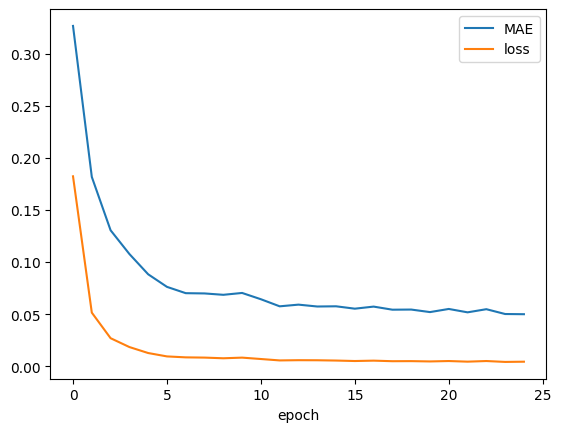

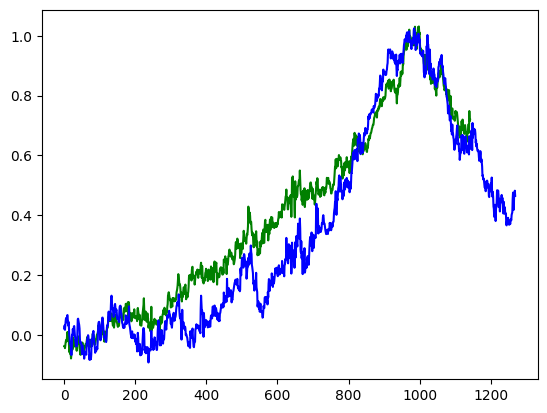

In [41]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()

In [81]:
#prepare all predictions
#lstm
print('single LSTM model MSFT Vs Google')
msft_lstm_mse, msft_lstm_mae = compute_metrics(y_test, LSTM_MSFT_test)
goog_lstm_mse, goog_lstm_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(LSTM_GOOG_yhat))

print('single hybrid model MSFT Vs Google')
#single hybrid
msft_single_mse, msft_single_mae = compute_metrics(MSFT_y_test, MSFT_predictions)
goog_single_mse, goog_single_mae = compute_metrics(google_scaler.inverse_transform(GOOG_y_test), google_scaler.inverse_transform(GOOG_predictions))

print('single linear model MSFT Vs Google')
#Single linear hybrid
msft_sing_linear_mse, msft_sing_linear_mae = compute_metrics(y_test, linear_predictions_MSFT)
goog_sing_linear_mse, goog_sing_linear_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(linear_predictions_GOOG))

print('expanded hybrid model MSFT Vs Google')
#expanded_hybrid
msft_expanded_mse, msft_expanded_mae = compute_metrics(msft_y, msft_predictions)
goog_expanded_mse, goog_expanded_mae = compute_metrics(goog_y, goog_predictions)

print('expanded linear model MSFT Vs Google')
#Expanded linear hybrid
msft_exlin_mse, msft_exlin_mae = compute_metrics(y_test, linear_ex_msft)
goog_exlin_mse, goog_exlin_mae = compute_metrics(google_target, linear_ex_goog)

single LSTM model MSFT Vs Google
the mean square error of the predictions is 0.0010364145273342729, and the mean absolute error of the predictions is 0.02597641758620739
the mean square error of the predictions is 26.834592819213867, and the mean absolute error of the predictions is 4.314876079559326
single hybrid model MSFT Vs Google
the mean square error of the predictions is 0.015870852395892143, and the mean absolute error of the predictions is 0.10145285725593567
the mean square error of the predictions is 31.342330932617188, and the mean absolute error of the predictions is 4.751354217529297
single linear model MSFT Vs Google
the mean square error of the predictions is 0.012759757228195667, and the mean absolute error of the predictions is 0.09122755378484726
the mean square error of the predictions is 23.79026222229004, and the mean absolute error of the predictions is 4.127116680145264
expanded hybrid model MSFT Vs Google
the mean square error of the predictions is 0.0046115810

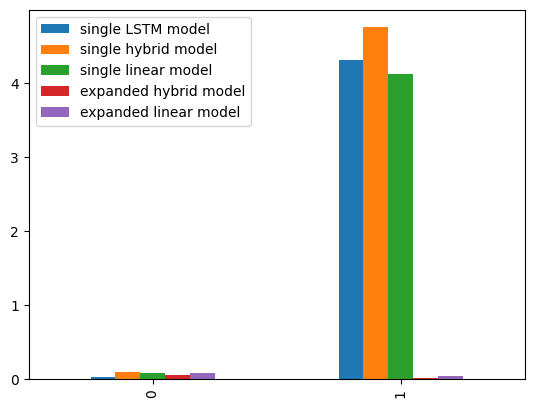

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

mae= {
      'single LSTM model':[ msft_lstm_mae,goog_lstm_mae], 
      'single hybrid model':[ msft_single_mae, goog_single_mae],
      'single linear model':[msft_sing_linear_mae, goog_sing_linear_mae],
      'expanded hybrid model':[msft_expanded_mae, goog_expanded_mae],
      'expanded linear model':[msft_exlin_mae, goog_exlin_mae]
      }



pd.DataFrame(mae).plot(kind='bar' )
plt.show()


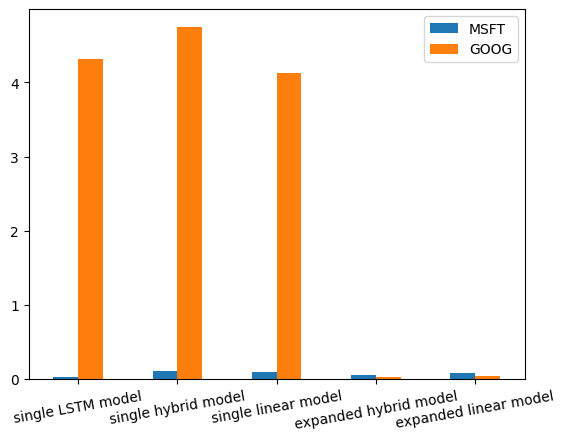

In [121]:
MSFT = [ msft_lstm_mae, msft_single_mae,msft_sing_linear_mae, msft_expanded_mae, msft_exlin_mae]
GOOG = [ goog_lstm_mae, goog_single_mae,goog_sing_linear_mae, goog_expanded_mae, goog_exlin_mae]
index = ['single LSTM model', 'single hybrid model', 'single linear model',  'expanded hybrid model', 'expanded linear model']
df = pd.DataFrame({'MSFT': MSFT,
                   'GOOG': GOOG}, index=index)
ax = df.plot.bar(rot=10)